### MNIST Handwritten Digit Recognizer With Live Video Feed
<pre>
Authors            : Rajendra Bhagroo  | Christopher Guevarra
Emails             : Rbhagroo@Nyit.edu | Cguevarr@nyit.edu

Course Name        : Artificial Intelligence 1
Course Number      : CSCI 355 - W01D
Course Instructor  : Maherukh Akhtar

Date Due           : 12/10/18
Date Last Modified : 11/21/18
Kernel             : Python 3.6.6

Credits: 
* Yassine Ghouzam  : https://bit.ly/2Tz2u9N
* Jason Brownlee   : https://bit.ly/2vtcCUe
</pre>

In [2]:
# Install pip packages for the current Jupyter kernel
from sys import executable

!{executable} -m pip install --upgrade pip
!{executable} -m pip install matplotlib
!{executable} -m pip install keras
!{executable} -m pip install opencv-python

# Python 3.6 Compatable: https://www.tensorflow.org/install/pip
!{executable} -m pip install --upgrade tensorflow

Requirement already up-to-date: pip in c:\users\jacob\appdata\local\programs\python\python36\lib\site-packages (18.1)
Requirement already up-to-date: tensorflow in c:\users\jacob\appdata\local\programs\python\python36\lib\site-packages (1.12.0)


In [1]:
'''
Sets matplotlib's backend engine to display plots within current Jupyter kernel
Sets Tensorflow as backend engine
'''
%matplotlib inline
import tensorflow as tf
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2

# https://keras.io/datasets/#mnist-database-of-handwritten-digits
# To implement different dataset see: http://yann.lecun.com/exdb/mnist/
from keras.datasets import mnist

# Keras is a high level API that will use TensorFlow for its backend engine
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

# Allows us to save [dump] and load models
import pickle

Using TensorFlow backend.


In [2]:
# Random Numbers Seeded [Fixed] for reproducability
np.random.seed(5)

# Load Data
'''
Dataset Info:
    28x28 greyscale images [Digits 0-9]
    Training Set: 60,000 images
    Testing Set: 10,000 images
    X_train, X_test: uint8 array of grayscale image data with shape (num_samples, 28, 28)
    y_train, y_test: uint8 array of digit labels (integers in range 0-9) with shape (num_samples,)
'''
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# Preprocess Data
'''
Inspecting the data, we can see that we are working with a numpy array with shape (60000, 28, 28)

Shape:
    Number Of Samples: 60,000
    Rows    [pixels] : 28
    Columns [pixels] : 28
'''

print(f'''
Before Manipulation
    X_train class type: {type(X_train)}
    X_train data type: {X_train.dtype}
    X_train shape: {X_train.shape}
''')


# Reshape Data
'''
Reshape numpy array from 3D to 4D, resembling [samples][channels][width][height]
1 channel = greyscale images, we would use 3 channels for RGB colored images.

We will also change the datatype from uint8 to float32 to work with decimal range [0-1]
'''

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

print(f'''
After Manipulation
    X_train class type: {type(X_train)}
    X_train data type: {X_train.dtype}
    X_train shape: {X_train.shape}
''')


Before Manipulation
    X_train class type: <class 'numpy.ndarray'>
    X_train data type: uint8
    X_train shape: (60000, 28, 28)


After Manipulation
    X_train class type: <class 'numpy.ndarray'>
    X_train data type: float32
    X_train shape: (60000, 1, 28, 28)



In [4]:
# Normalize Data 
# Input images are represented by 8-bits, 0-255 range [RGB]. lets change the range to 0-1 [Greyscale]

print(f'''
Un-Normalized Array [RGB: 0-255]\n
{X_train[0][0][8]}
''')

X_train /= 255
X_test /= 255

print(f'''
Normalized Array [Greyscale: 0-1]\n
{X_train[0][0][8]}
''')


# One-Hot Encode Data
'''
Encode using one-of-K scheme. Converts raw values into numerical form to feed into model
Binary vector representation of categorical data
Example:                  0123456789
         Raw Digit [4] = [0001000000]
         Raw Digit [9] = [0000000010]
'''

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]
print(f"Number Of Classes: {num_classes}")


Un-Normalized Array [RGB: 0-255]

[  0.   0.   0.   0.   0.   0.   0.  18. 219. 253. 253. 253. 253. 253.
 198. 182. 247. 241.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


Normalized Array [Greyscale: 0-1]

[0.         0.         0.         0.         0.         0.
 0.         0.07058824 0.85882354 0.99215686 0.99215686 0.99215686
 0.99215686 0.99215686 0.7764706  0.7137255  0.96862745 0.94509804
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]

Number Of Classes: 10


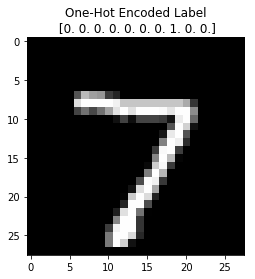

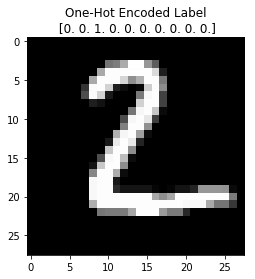

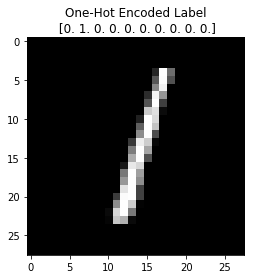

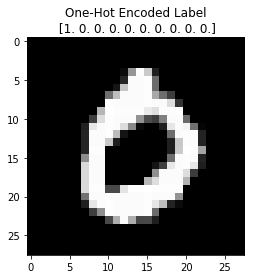

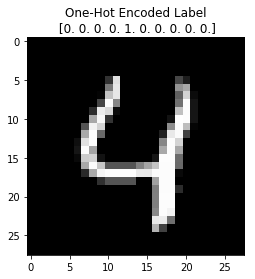

In [5]:
# Plot Data

'''
Using Matplotlib to plot the first 5 images in the test set, labels included in one-hot form
Remember This Example?

Example:                  0123456789
         Raw Digit [4] = [0001000000]
         Raw Digit [9] = [0000000010]
'''
for i in range(5):
    
    # Grab image and process
    image = X_test[i]
    image = np.array(image, dtype='float32')
    pixels = image.reshape((28, 28))
    
    # Plot image with corresponding one-hot encoded label 
    plt.title(f'One-Hot Encoded Label\n {y_test[i]}')
    plt.imshow(pixels, cmap='gray')
    plt.show()

In [6]:
# Define Model

# "th" mode means that the images should have shape (samples, channels, height, width)
# "tf" mode means that the images should have shape (samples, height, width, channels)
K.set_image_dim_ordering('th')

'''
Deep learning models & layers pose a lengthy explanation.
It is HIGHLY recommended to check out the documentation on Keras!
https://keras.io/
'''
def build_cnn():
    # Sequential model is a linear stack of layers, hence "deep" learning
    model = Sequential()


    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Dropout(rate=0.2))
    model.add(Flatten())
    
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=50, activation='relu'))
    
    model.add(Dense(units=num_classes, activation='softmax'))
    
    # Compile Model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [2]:
'''
# Build Model
model = build_cnn()

# Train Model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)
'''

'\n# Build Model\nmodel = build_cnn()\n\n# Train Model\nmodel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)\n'

In [ ]:
'''
# Evaluate Model
scores = model.evaluate(X_test, y_test, verbose=1)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

# Save Model To Disk
filename = 'MNIST_CNN_Model.sav'
pickle.dump(model, open(filename, 'wb'))
print(f'Successfully Saved: {filename}')
'''

In [2]:
#Load Model From Disk
filename = 'MNIST_CNN_Model.sav'
model = pickle.load(open(filename,'rb'))
print(f'Successfully Loaded: {filename}')

Successfully Loaded: MNIST_CNN_Model.sav


In [3]:
# OpenCV - SPACE to take frame, ESC to close video source

# There is one camera, so init VideoCapture with arg 0
video_feed = cv2.VideoCapture(0)
cv2.namedWindow("Numeric Image")
img_counter = 0
# Set video_feed dimension to 28x28 to match dataset dimensions
video_feed.set(3, 28)
video_feed.set(4, 28) 
while True:
    is_frame_saved, frame= video_feed.read()

    if not is_frame_saved:
        break
    key = cv2.waitKey(5)
    cv2.imshow("Numeric Image Win", frame)
    if (key % 256 == 27):
        # ESC pressed
        video_feed.release()
        cv2.destroyAllWindows()
        print("Terminating Video Source...")
        break
    elif (key % 256 == 32):
        # SPACE pressed
        img_name = f"Numeric_Image_{img_counter}.png"
        cv2.imwrite(img_name, frame)
        print(f"{img_name} successfully written")
        img_counter += 1

video_feed.release()
cv2.destroyAllWindows()


Numeric_Image_0.png successfully written
Terminating Video Source...


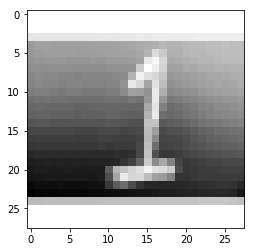

In [4]:
# Display & manipulate loaded image, and normalize the input
loaded_img = cv2.imread('Numeric_Image_0.png', cv2.IMREAD_GRAYSCALE) 
loaded_img = cv2.resize(loaded_img, (28, 28), interpolation = cv2.INTER_AREA)
loaded_img = cv2.bitwise_not(loaded_img)
imgplot = plt.imshow(loaded_img, cmap='gray')
plt.show()

In [5]:
# Use model to make prediction
prediction = model.predict_classes(loaded_img.reshape((1, 1, 28, 28)))
print(f'Model prediction: {prediction}')

Model prediction: [3]
